# **Imports and Constants**

In [1]:
# find spark
import findspark
findspark.init()

In [2]:
# imports
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size, isnan, array_contains, when, count, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics
import pathlib
import platform

# env variables
if platform.system() == 'Windows':
    %env PYSPARK_DRIVER_PYTHON = python
    %env PYSPARK_PYTHON = python
elif platform.system() == 'Linux':
    %env PYSPARK_DRIVER_PYTHON = python
    %env PYSPARK_PYTHON = python3
else:
    %env PYSPARK_DRIVER_PYTHON = python3.6
    %env PYSPARK_PYTHON = python3.6

# incompatibility with Pyarrow
# need to install Pyarrow 0.14.1 or lower or Set the environment variable ARROW_PRE_0_15_IPC_FORMAT=1
%env ARROW_PRE_0_15_IPC_FORMAT = 1

# used versions:
# spark='2.4.3' python='3.6' pyarrow='0.14.1'

# for new system:
# import findspark
# findspark.init()
# %pip install numpy
# %pip install -U matplotlib
# %pip install pandas
# %pip install Pyarrow==0.14.0
# %env PYSPARK_DRIVER_PYTHON=python
# %env PYSPARK_PYTHON=python

env: PYSPARK_DRIVER_PYTHON=python3.6
env: PYSPARK_PYTHON=python3.6
env: ARROW_PRE_0_15_IPC_FORMAT=1


In [3]:
# paths

BASE_PATH = pathlib.Path().absolute()

KMEANS_REL_PATH = os.path.join(os.path.join(os.path.join(
    "Datasets", "Irish"), "CER Electricity Revised March 2012"), "kmeans models")
DATASET_REL_PATH = os.path.join(
    os.path.join("Datasets", "Irish"), "CER Electricity Revised March 2012")


DATASET_PATH = os.path.join(BASE_PATH, DATASET_REL_PATH)
KMEANS_PATH = os.path.join(BASE_PATH, KMEANS_REL_PATH)

print(DATASET_PATH)
print(KMEANS_PATH)

#from google.colab import drive
# drive.mount('/gdrive')

/Users/Soroush/Desktop/Thesis/Code/Datasets/Irish/CER Electricity Revised March 2012
/Users/Soroush/Desktop/Thesis/Code/Datasets/Irish/CER Electricity Revised March 2012/kmeans models


# **Dataset**

In [4]:
# load and save .read_pickle() and .to_pickle()

# save
# dataset.to_pickle(DATASET_PATH+"dataset.pkl")
# aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
# json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
# dataset.to_csv(DATASET_PATH+"dataset.csv")
# aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
# json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
# aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")

# load
#dataset = pd.read_pickle(os.path.join(DATASET_PATH, 'dataset.pkl'))
#aggregated_dataset = pd.read_pickle(os.path.join(DATASET_PATH, 'aggregated_dataset.pkl'))

#.pkl to .csv
#dataset = pd.read_pickle(os.path.join(DATASET_PATH, 'irish_aggregated_dataset.pkl'))
#dataset.to_csv(os.path.join(DATASET_PATH, 'irish_aggregated_dataset.csv'))


# **Functions**

## **Malicious Samples**

In [5]:
# Generate malicious samples
def h1(x):
    MAX = 0.8
    MIN = 0.1
    alpha = random.uniform(MIN, MAX)
    temp = np.array(x)
    return (temp*alpha).tolist()


def h2(x):
    MIN_OFF = 4  # hour
    DURATION = random.randint(MIN_OFF, 23)
    START = random.randint(0, 23-DURATION) if DURATION != 23 else 0
    END = START+DURATION
    temp = []
    for i in range(len(x)):
        if i < START or i >= END:
            temp.append(x[i])
        else:
            temp.append(0.0)
    return temp


def h3(x):
    MAX = 0.8
    MIN = 0.1
    temp = []
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN, MAX))
    return temp


def h4(x):
    MAX = 0.8
    MIN = 0.1
    mean = np.mean(x)
    temp = []
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN, MAX))
    return temp


def h5(x):
    MAX = 0.8
    MIN = 0.1
    mean = np.mean(x)
    temp = []
    for i in range(len(x)):
        temp.append(mean)
    return temp


def h6(x):
    temp = np.array(x)
    # temp=temp[::-1]
    temp = np.flipud(temp)
    return temp.tolist()


# add malicious samples
def create_malicious_df(sdf):
    def random_attack_assigner(x):
        NUMBER_OF_MALICIOUS_GENERATOR = 6
        res = []
        for row in x:
            rand = random.randint(1, NUMBER_OF_MALICIOUS_GENERATOR)
            if rand == 1:
                temp = (h1(row))
            elif rand == 2:
                temp = (h2(row))
            elif rand == 3:
                temp = (h3(row))
            elif rand == 4:
                temp = (h4(row))
            elif rand == 5:
                temp = (h5(row))
            elif rand == 6:
                temp = (h6(row))
            res.append(temp)
        return pd.Series(res)
    random_attack_assigner_UDF = pandas_udf(
        random_attack_assigner, returnType=ArrayType(FloatType()))
    # sdf_malicious=sdf
    N = False
    sdf = sdf.withColumn("N", f.lit(N))  # malicious sample
    # change '#' column number to negative
    sdf = sdf.withColumn("#", col("#")*-1)
    sdf = sdf.withColumn("power", random_attack_assigner_UDF(col("power")))
    # sdf=sdf.drop('statistics')
    sdf = sdf.withColumn("statistics", generate_feature_UDF(col("power")))
    sdf = add_statistics_column(sdf)  # for update statistics
    return sdf.select(sdf.columns)  # to reorder columns

In [6]:
# plot
def plot_malicious_samples():

    read_value = [3.4803431034088135, 2.529871702194214, 2.2175486087799072, 2.629481077194214, 2.9629790782928467, 2.0697860717773438, 2.900712251663208, 2.926414966583252, 4.8191237449646, 4.156486988067627, 2.6474769115448, 2.1933677196502686,
                  2.261159658432007, 2.340345621109009, 2.7386586666107178, 3.2414891719818115, 1.8946533203125, 3.1397650241851807, 2.8951449394226074, 3.4589333534240723, 2.726524829864502, 6.511429309844971, 3.4918391704559326, 3.787257432937622]
    lists = []
    colors = ['b', 'r-', 'g--', 'c:', 'm-.', 'y-', 'k--']
    lists.append(read_value)
    lists.append(h1(read_value))
    lists.append(h2(read_value))
    lists.append(h3(read_value))
    lists.append(h4(read_value))
    lists.append(h5(read_value))
    lists.append(h6(read_value))
    #font = {'size': 12}
    #plt.rc('font', **font)
    plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("time (hour)", fontsize=18)
    plt.ylabel("usage (kw)", fontsize=18)
    #plt.title("malicious samples")
    plt.xticks(np.arange(0, 24, step=1))
    plt.plot(read_value)
    for i in range(len(lists)):
        if i == 0:
            plt.plot(lists[i], colors[i], label='normal usage')
        else:
            plt.plot(lists[i], colors[i], label='attack %s' % i)
    # plt.legend()
    plt.legend(prop={'size': 14})
    plt.savefig('attack.pdf', bbox_inches='tight')
    # plt.savefig('attack.eps', format='eps')
    plt.show()
    return None

# plot_malicious_samples()

## **Prepare Spark Dataset**

In [27]:
# rename columns
def rename_dataframe(sdf):
    names = ['#', 'id', 'date', 'power']
    for c, n in zip(sdf.columns, names):
        sdf = sdf.withColumnRenamed(c, n)
    return sdf

# sdf=rename_dataframe(sdf)
# sdf.show()

# convert power to array


def string_power_to_array(sdf):
    temp = sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""), "\\]", "")
                          .alias("power"))
    temp = temp.withColumn("power", split(col("power"), ",\s*")
                           .cast(ArrayType(FloatType())).alias("power"))
    return temp

# sdf=string_power_to_array(sdf)
# sdf.show()


def add_validation_column(sdf):
    def validation(x):
        res = []
        for row in x:
            v = True
            if (len(row) != 24 or  # unusual size
                (row >= 0).sum() != 24 or  # number of valid elements = 24
                # sum(n >= 0 for n in row) != 24 or
                # equal or more than 3 zero elements
                np.count_nonzero(row == 0) >= 3 or
                    sum(n < 0 for n in row) > 0):  # not have negative element
                v = False
            res.append(v)
        return pd.Series(res)
    validation_UDF = pandas_udf(validation, returnType=BooleanType())
    temp = sdf.withColumn("V", validation_UDF(col("power")))
    return temp

# sdf=add_validation_column(sdf)
# sdf.show()


# add "N"ormal consumption ("N"onmalicious) column
def add_Normal_column(sdf):
    N = True
    temp = sdf.withColumn("N", f.lit(N))
    return temp

# sdf=add_Normal_column(sdf)
# sdf.show()

# filter data
def filter_dataset(sdf, from_date="BEGIN", to_date="END", ID="*", V="*"):
    temp = sdf
    if (from_date != "BEGIN"):
        temp = temp.filter(sdf.date > from_date)  # filter date (from X)
    if (to_date != "END"):
        temp = temp.filter(sdf.date < to_date)  # filter date (to Y)
    if (ID != "*"):
        temp = temp.filter(sdf.id == ID)  # filter IDs
    if (V != "*"):
        temp = temp.filter(sdf.V == V)  # filter validation
    return temp

# sdf=filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="Apt36",V="True")
# sdf.show()


def split_power(sdf):
    temp = sdf.select("#", "date", "id",
                      sdf.power[0].alias("H0"), sdf.power[1].alias(
                          "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                      sdf.power[4].alias("H4"), sdf.power[5].alias(
                          "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                      sdf.power[8].alias("H8"), sdf.power[9].alias(
                          "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                      sdf.power[12].alias("H12"), sdf.power[13].alias(
                          "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                      sdf.power[16].alias("H16"), sdf.power[17].alias(
                          "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                      sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"))
    return temp

# split_sdf=split_power(sdf)
# sdf.show()

# make id list
def get_ids(sdf):
    IDs = np.array(sdf.select("id").distinct().collect())
    #IDs = IDs.reshape(1, len(IDs))
    IDs = IDs.flatten() 
    return IDs

# number of instances per id
def get_instance_number_per_id(sdf):
    IDs = np.array(sdf.select("id").distinct().collect())
    IDs = IDs.flatten() 
    id_instance_dict =	{}
    
    for i in IDs:
        temp = sdf.filter(sdf.id == int(i))
        row_number = temp.count()
        id_instance_dict[int(i)] = row_number
    
    return id_instance_dict



# generate uniqe id
def generate_uniqe_id(sdf):
    temp = sdf
    temp = temp.withColumn("uid", f.concat(
        col("id"), f.lit("-"), col("#")).alias("uid"))
    return temp

# sdf=generate_uniqe_id(sdf)


# generate feature
def generate_feature(x):
    res = []
    for row in x:
        row = np.array(row)  # to numpy
        statistics = []
        min_val = np.nanmin(row)
        max_val = np.nanmax(row)
        mean_val = np.nanmean(row)
        std_val = np.nanstd(row)
        statistics.append(mean_val)
        statistics.append(std_val)
        statistics.append(min_val)
        statistics.append(max_val)
        res.append(statistics)
    return pd.Series(res)


generate_feature_UDF = pandas_udf(
    generate_feature, returnType=ArrayType(FloatType()))


def add_statistics_column(sdf):
    temp = sdf.withColumn("statistics", generate_feature_UDF(col("power")))
    return temp

# sdf=add_statistics_column(sdf)
# sdf.show()


# sdf.show()
# print("number of rows: " + str(sdf.count()))
# sdf.collect()
# sdf.printSchema()
# split_sdf=add_validation_column(split_sdf)

# **Models**

## **K-Means**

In [8]:
def prepare_for_kmeans(sdf):

    temp = sdf

    # define function for split power column
    def split(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias(
                              "H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"),
                          sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"), sdf.statistics[3].alias("S3"))
        return temp

    # call the split_power function
    temp = split(temp)

    # filter date
    # temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    # temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'S0', 'S1', 'S2', 'S3']

    # call the generate_uniqe_id function
    temp = generate_uniqe_id(temp)

    # make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_kmeans = vecAssembler.transform(
        temp).select(col("uid"), col("features"))
    return df_kmeans

In [9]:
# run k-means


def kmeans(sdf_kmeans):
    # find best k
    MAX_k = 3
    costs = np.zeros(MAX_k)
    silhouettes = np.zeros(MAX_k)
    silhouettes[1] = 0  # set value for k=1
    for k in range(2, MAX_k):
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(sdf_kmeans)
        costs[k] = model.computeCost(sdf_kmeans)  # requires Spark 2.0 or later
        predictions = model.transform(sdf_kmeans)
        evaluator = ClusteringEvaluator()
        silhouettes[k] = evaluator.evaluate(predictions)

    # show silhouette
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(range(2, MAX_k), silhouettes[2:MAX_k])
    ax.set_xlabel('k')
    ax.set_ylabel('silhouette')

    # show cost
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(range(2, MAX_k), costs[2:MAX_k])
    ax.set_xlabel('k')
    ax.set_ylabel('cost')

    # find best k
    best_k = np.argmax(silhouettes)
    print("maximum value of silhouette is: " +
          str(silhouettes[best_k]) + " in index: " + str(best_k))

    # Trains a k-means model.
    kmeans = KMeans().setK(best_k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)

    # Make predictions
    predictions = model.transform(sdf_kmeans)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
#     print("Silhouette with squared euclidean distance = " + str(silhouette))

#     # Shows the result.
#     centers = model.clusterCenters()
#     print("Cluster Centers: ")
#     for center in centers:
#         print(center)

#     transformed = model.transform(sdf_kmeans).select('id', 'prediction')
#     transformed.show()
#     transformed.groupby('prediction').count().show()
#     rows = transformed.collect()
#     prediction = spark.createDataFrame(rows)
#     prediction.show()
    return model, best_k, silhouette  # silhouettes: new

## **Decision Tree Methods**

In [10]:
def prepare_for_decision_tree_methods(sdf):

    temp = sdf

    # define function for split power column
    def split(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias(
                              "H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"),
                          sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"), sdf.statistics[3].alias("S3"))
        return temp

    # call the split_power function
    temp = split(temp)

    # boolean to string (for "N" column)
    temp = temp.withColumn("N", f.col("N").cast('string'))
    # temp.printSchema()

    # filter date
    # temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    # temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'S0', 'S1', 'S2', 'S3']

    # call the generate_uniqe_id function
    # temp=generate_uniqe_id(temp)

    # make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))

    # make label ready
    indexer = StringIndexer(inputCol="N", outputCol="NIndex")
    output_fixed = indexer.fit(output).transform(output)

    final_data = output_fixed.select("features", 'NIndex')
    return final_data

In [11]:
# run decision tree methods
def decision_tree(train_data, test_data):
    dtc = DecisionTreeClassifier(labelCol='NIndex', featuresCol='features')
    rfc = RandomForestClassifier(
        labelCol='NIndex', featuresCol='features')  # ,numTrees=100
    gbt = GBTClassifier(labelCol='NIndex', featuresCol='features')

    dtc_model = dtc.fit(train_data)
    rfc_model = rfc.fit(train_data)
    gbt_model = gbt.fit(train_data)

    dtc_predictions = dtc_model.transform(test_data)
    rfc_predictions = rfc_model.transform(test_data)
    gbt_predictions = gbt_model.transform(test_data)

    # evaluation
    # Select (prediction, true label) and compute test error
    acc_evaluator = MulticlassClassificationEvaluator(
        labelCol="NIndex", predictionCol="prediction", metricName="accuracy")

    dtc_acc = acc_evaluator.evaluate(dtc_predictions)
    rfc_acc = acc_evaluator.evaluate(rfc_predictions)
    gbt_acc = acc_evaluator.evaluate(gbt_predictions)

    # new:
    # Let's use the run-of-the-mill evaluator
    evaluator = BinaryClassificationEvaluator(labelCol='NIndex')
    # We have only two choices: area under ROC and PR curves :-(
    dtc_auroc = evaluator.evaluate(
        dtc_predictions, {evaluator.metricName: "areaUnderROC"})
    dtc_auprc = evaluator.evaluate(
        dtc_predictions, {evaluator.metricName: "areaUnderPR"})
    rfc_auroc = evaluator.evaluate(
        rfc_predictions, {evaluator.metricName: "areaUnderROC"})
    rfc_auprc = evaluator.evaluate(
        rfc_predictions, {evaluator.metricName: "areaUnderPR"})
    gbt_auroc = evaluator.evaluate(
        gbt_predictions, {evaluator.metricName: "areaUnderROC"})
    gbt_auprc = evaluator.evaluate(
        gbt_predictions, {evaluator.metricName: "areaUnderPR"})
    #print("DT Area under ROC Curve: {:.4f}".format(dtc_auroc))
    #print("DT Area under PR Curve: {:.4f}".format(dtc_auprc))
    #print("RF Area under ROC Curve: {:.4f}".format(rfc_auroc))
    #print("RF Area under PR Curve: {:.4f}".format(rfc_auprc))
    #print("GB Area under ROC Curve: {:.4f}".format(gbt_auroc))
    #print("GB Area under PR Curve: {:.4f}".format(gbt_auprc))

    #print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
    #print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
    #print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

    return dtc_acc, dtc_auroc, dtc_auprc, rfc_acc, rfc_auroc, rfc_auprc, gbt_acc, gbt_auroc, gbt_auprc

## **PCA**

In [12]:
def prepare_for_pca(sdf):

    temp = sdf

    # define function for split power column
    def split_power(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"))
        return temp

    # call the split_power function
    temp = split_power(temp)

    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23']

    # call the generate_uniqe_id function
    temp = generate_uniqe_id(temp)

    # make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_pca = vecAssembler.transform(temp).select(
        "#", "V", "N", "date", "id", "uid", col("features"))
    return df_pca


def pca_for_tree(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select(
        "NIndex", col("pcaFeatures").alias("features"))
    return result


def pca_for_kmeans(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select(
        "uid", col("pcaFeatures").alias("features"))
    return result


# sdf_pca=pca(sdf)
# sdf_pca.show() #truncate=False

## **MLP**

In [13]:
def prepare_for_mlp(sdf):

    temp = sdf

    # define function for split power column
    def split(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias(
                              "H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"),
                          sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"), sdf.statistics[3].alias("S3"))
        return temp

    # call the split_power function
    temp = split(temp)

    # boolean to string (for "N" column)
    temp = temp.withColumn("N", f.col("N").cast('string'))
    # temp.printSchema()

    # filter date
    # temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    # temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'S0', 'S1', 'S2', 'S3']

    # call the generate_uniqe_id function
    # temp=generate_uniqe_id(temp)

    # make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))

    # make label ready
    indexer = StringIndexer(inputCol="N", outputCol="label")
    output_fixed = indexer.fit(output).transform(output)

    final_data = output_fixed.select("features", 'label')
    return final_data

In [14]:
# run mlp method
def mlp(train_data, test_data, layers=[28, 50, 10, 2]):
    # specify layers for the neural network:
    # input layer of size 4 (features), two intermediate of size 5 and 4
    # and output of size 3 (classes)

    # create the trainer and set its parameters
    trainer = MultilayerPerceptronClassifier(
        maxIter=100, layers=layers, blockSize=128, seed=1234)

    # train_data.show()
    # train the model
    model = trainer.fit(train_data)

    # compute accuracy on the test set
    result = model.transform(test_data)
    predictionAndLabels = result.select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator(
        metricName="accuracy")  # BinaryClassificationEvaluator
    acc = evaluator.evaluate(predictionAndLabels)
    print("Test set accuracy = " + str(acc))
    return acc

# **Main**

In [31]:
# create SparkSession
spark = SparkSession.builder.appName(
    "anomaly_detection").master("local[20]").getOrCreate()
# network problem? type it in commandline: sudo hostname -s 127.0.0.1

# define schema
schema = StructType([
    StructField("#", IntegerType()),
    StructField("id", TimestampType()),
    StructField("date", StringType()),
    StructField("power", StringType())])

# read data
sdf = spark.read.format('csv').options(header='true', inferSchema=True, schema=schema).load(
    os.path.join(DATASET_PATH, 'irish_aggregated_dataset.csv'))


sdf = rename_dataframe(sdf)
sdf = string_power_to_array(sdf)
sdf = add_statistics_column(sdf)
sdf = add_validation_column(sdf)
sdf = add_Normal_column(sdf)
#sdf = filter_dataset(sdf, from_date="BEGIN",to_date="END", ID="1000", V="True")
sdf = filter_dataset(sdf, from_date="2010-07-15",to_date="2010-07-21", ID="*", V="True")
sdf = generate_uniqe_id(sdf)

# ids
id_list = get_ids(sdf)

# number of instances per id
dic_instance_number_per_id = get_instance_number_per_id(sdf)


# #dataset
# print("dataframe schema:")
# print("number of rows: " + str(sdf.count()))
# sdf.printSchema()
#print("benign dataframe (sdf):")
#sdf.show()

# #generate malicious data
#sdf_malicious = create_malicious_df(sdf)
#print("malicious dataframe (sdf_malicious):")
#sdf_malicious.show()

#sdf_mix = sdf.union(sdf_malicious)
#print("final dataframe (sdf_mix):")
#sdf_mix.show()

[1088 1238 1342 ... 6721 6819 7166]


In [ ]:
# collect a row
# sdf.collect()[1][3] #[8027][3] is used for figure

-------------------- k-means started!
customer 1: 1000
maximum value of silhouette is: 0.3108565158404826 in index: 2
AAAAAAAAAA
+----+---+------------------+
|  id|  k|        Silhouette|
+----+---+------------------+
|1000|  2|0.3108565158404826|
+----+---+------------------+



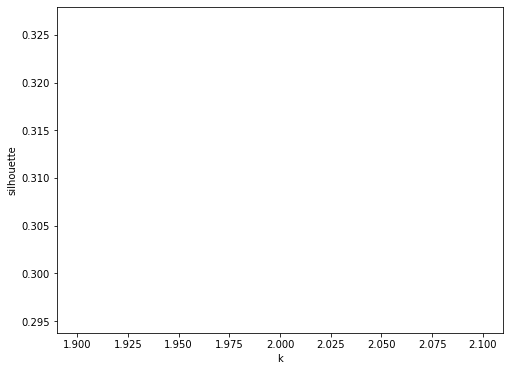

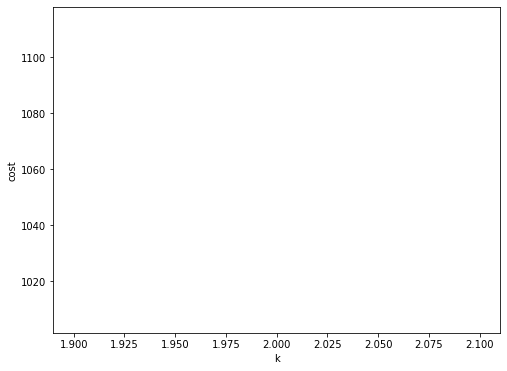

In [18]:
# kmeans separately


def call_kmeans(sdf):

    # create statistics dataframe
    kmeans_statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("k", IntegerType()),
        StructField("Silhouette", FloatType())])

    kmeans_statistics = spark.createDataFrame([], kmeans_statistics_schema)

    id_list = get_ids(sdf)
    # replace sdf with final_sdf for clustring benign and malicious data
    sdf_kmeans = prepare_for_kmeans(sdf)
    # sdf_kmeans=pca_for_kmeans(sdf_kmeans) #0.8725788926917551 to 0.9101118371931005
    # sdf_kmeans.show()
    iteration = 1
    for i in np.nditer(id_list):
        sdf_kmeans_by_id = sdf_kmeans.filter(
            sdf_kmeans.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))
        # sdf_kmeans_by_id.show()
        kmeans_model, best_k, silhouette = kmeans(sdf_kmeans_by_id)
        # kmeans_model.save(os.path.join(KMEANS_PATH,str(i)))
        summary = kmeans_model.summary
        if summary.clusterSizes[1] > 200:
            print("AAAAAAAAAA")
        else:
            print("BBBBBBBBBB")

        newRow_for_statistics = spark.createDataFrame(
            [(str(i), int(best_k), float(silhouette))])
        kmeans_statistics = kmeans_statistics.union(newRow_for_statistics)

        iteration += 1
        # model_name = KMeansModel.load(os.path.join(KMEANS_PATH,str(i)) #for load model
    return kmeans_statistics


print("-------------------- k-means started!")
kmeans_statistics = call_kmeans(sdf)
kmeans_statistics.show()
# save
# result_pdf = kmeans_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
# df.head()
# df.describe()

In [ ]:
# decision tree separately
def call_trees(sdf):

    # create statistics dataframe
    trees_statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("dtc_acc", FloatType()),
        StructField("dtc_auroc", FloatType()),
        StructField("dtc_auprc", FloatType()),
        StructField("rfc_acc", FloatType()),
        StructField("rfc_auroc", FloatType()),
        StructField("rfc_auprc", FloatType()),
        StructField("gbt_acc", FloatType()),
        StructField("gbt_auroc", FloatType()),
        StructField("gbt_auprc", FloatType())])

    trees_statistics = spark.createDataFrame([], trees_statistics_schema)

    id_list = get_ids(sdf)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_trees_by_id = sdf.filter(
            sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_trees_by_id_malicious = create_malicious_df(sdf_trees_by_id)
        sdf_trees_by_id_mixed = sdf_trees_by_id.union(
            sdf_trees_by_id_malicious)

        # sdf_trees=prepare_for_decision_tree_methods(sdf)

        sdf_trees = prepare_for_decision_tree_methods(sdf_trees_by_id_mixed)
        train_data, test_data = sdf_trees.randomSplit([0.7, 0.3])

        dtc_acc, dtc_auroc, dtc_auprc, rfc_acc, rfc_auroc, rfc_auprc, gbt_acc, gbt_auroc, gbt_auprc = decision_tree(
            train_data, test_data)

        print('A single decision tree had an accuracy of: {0:2.2f}%'.format(
            dtc_acc*100))
        print("DT Area under ROC Curve: {:.4f}".format(dtc_auroc))
        print("DT Area under PR Curve: {:.4f}".format(dtc_auprc))
        print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(
            rfc_acc*100))
        print("RF Area under ROC Curve: {:.4f}".format(rfc_auroc))
        print("RF Area under PR Curve: {:.4f}".format(rfc_auprc))
        print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(
            gbt_acc*100))
        print("GB Area under ROC Curve: {:.4f}".format(gbt_auroc))
        print("GB Area under PR Curve: {:.4f}".format(gbt_auprc))

        newRow_for_statistics = spark.createDataFrame([(str(i), float(dtc_acc), float(dtc_auroc), float(dtc_auprc),
                                                        float(rfc_acc), float(
                                                            rfc_auroc), float(rfc_auprc),
                                                        float(gbt_acc), float(gbt_auroc), float(gbt_auprc))])
        trees_statistics = trees_statistics.union(newRow_for_statistics)

        iteration += 1
    return trees_statistics


#print("-------------------- decision tree started!")
# trees_statistics=call_trees(sdf)
# trees_statistics.show()
# save
# result_pdf = trees_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'trees_statistics.pkl'))
# load
df = pd.read_pickle(os.path.join(BASE_PATH, 'all_statistics_trees_k1.pkl'))
df.head()
df.describe()

In [ ]:
# mlp separetely
def call_mlp(sdf):

    # create statistics dataframe
    mlp_statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("mlp", FloatType())])

    mlp_statistics = spark.createDataFrame([], mlp_statistics_schema)

    id_list = get_ids(sdf)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_trees_by_id = sdf.filter(
            sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_mlp = prepare_for_mlp(sdf)
        train_data, test_data = sdf_mlp.randomSplit([0.7, 0.3])

        acc = mlp(train_data, test_data, [28, 60, 10, 2])

        print('A MLP had an accuracy of: {0:2.2f}%'.format(acc*100))

        newRow_for_statistics = spark.createDataFrame([(str(i), float(acc))])
        mlp_statistics = mlp_statistics.union(newRow_for_statistics)

        iteration += 1
    return mlp_statistics

#print("-------------------- mlp started!")
# run
# mlp_statistics=call_mlp(sdf_mix)
# mlp_statistics.show()

# save
#df = statistics.select("*").toPandas()
#df.to_pickle(os.path.join(BASE_PATH, 'mlp_statistics.pkl'))

# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'mlp_statistics.pkl'))
# df.head()
# df.describe()

In [ ]:
# model tree
def call_model_with_tree(sdf):
    id_list = get_ids(sdf)

    # create statistics dataframe
    statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("k", IntegerType()),
        StructField("Silhouette", FloatType()),
        StructField("n_per_k", ArrayType(IntegerType())),
        StructField("dtc_acc", ArrayType(FloatType())),
        StructField("dtc_auroc", ArrayType(FloatType())),
        StructField("dtc_auprc", ArrayType(FloatType())),
        StructField("rfc_acc", ArrayType(FloatType())),
        StructField("rfc_auroc", ArrayType(FloatType())),
        StructField("rfc_auprc", ArrayType(FloatType())),
        StructField("gbt_acc", ArrayType(FloatType())),
        StructField("gbt_auroc", ArrayType(FloatType())),
        StructField("gbt_auprc", ArrayType(FloatType()))])

    statistics = spark.createDataFrame([], statistics_schema)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_kmeans = prepare_for_kmeans(sdf_by_id)

        # sdf_kmeans=pca_for_kmeans(sdf_kmeans)

        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model, best_k, silhouette = kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= " + str(best_k))

        transformed = kmeans_model.transform(
            sdf_kmeans).select('uid', 'prediction', 'features')
        # transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        # sdf_join.show()

        # define statistics variables
        n_per_k = []
        dtc_acc_list = []
        dtc_auroc_list = []
        dtc_auprc_list = []
        rfc_acc_list = []
        rfc_auroc_list = []
        rfc_auprc_list = []
        gbt_acc_list = []
        gbt_auroc_list = []
        gbt_auprc_list = []

        for k in range(0, best_k):
            temp_sdf = sdf_join.filter(sdf_join.prediction == k)
            temp_sdf_malicious = create_malicious_df(temp_sdf)
            temp_sdf_mixed = temp_sdf.union(temp_sdf_malicious)
            tree_data = prepare_for_decision_tree_methods(temp_sdf_mixed)

            # tree_data=pca_for_tree(tree_data)

            train_data, test_data = tree_data.randomSplit([0.7, 0.3])
            dtc_acc, dtc_auroc, dtc_auprc, rfc_acc, rfc_auroc, rfc_auprc, gbt_acc, gbt_auroc, gbt_auprc = decision_tree(
                train_data, test_data)
            print('A single decision tree had an accuracy of: {0:2.2f}%'.format(
                dtc_acc*100))
            print("DT Area under ROC Curve: {:.4f}".format(dtc_auroc))
            print("DT Area under PR Curve: {:.4f}".format(dtc_auprc))
            print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(
                rfc_acc*100))
            print("RF Area under ROC Curve: {:.4f}".format(rfc_auroc))
            print("RF Area under PR Curve: {:.4f}".format(rfc_auprc))
            print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(
                gbt_acc*100))
            print("GB Area under ROC Curve: {:.4f}".format(gbt_auroc))
            print("GB Area under PR Curve: {:.4f}".format(gbt_auprc))

            n_per_k.append(int(temp_sdf.count()))
            dtc_acc_list.append(float(dtc_acc))
            dtc_auroc_list.append(float(dtc_auroc))
            dtc_auprc_list.append(float(dtc_auprc))
            rfc_acc_list.append(float(rfc_acc))
            rfc_auroc_list.append(float(rfc_auroc))
            rfc_auprc_list.append(float(rfc_auprc))
            gbt_acc_list.append(float(gbt_acc))
            gbt_auroc_list.append(float(gbt_auroc))
            gbt_auprc_list.append(float(gbt_auprc))

        # update statistics
        newRow_for_statistics = spark.createDataFrame([(str(i), int(best_k), float(silhouette), n_per_k,
                                                        dtc_acc_list, dtc_auroc_list, dtc_auprc_list,
                                                        rfc_acc_list, rfc_auroc_list, rfc_auprc_list,
                                                        gbt_acc_list, gbt_auroc_list, gbt_auprc_list)])
        statistics = statistics.union(newRow_for_statistics)

        iteration += 1

    return statistics

# statistics=call_model_with_tree(sdf)
# statistics.show()

# save
# result_pdf = statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))


# load
df = pd.read_pickle(os.path.join(BASE_PATH, 'all_statistics_trees_k2to5.pkl'))
df.head()

# output of model
#df['dtc_acc_agg'] = [np.dot(df.n_per_k.to_numpy()[i],df.dtc.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
#df['rfc_acc_agg'] = [np.dot(df.n_per_k.to_numpy()[i],df.rfc.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
#df['gbt_acc_agg'] = [np.dot(df.n_per_k.to_numpy()[i],df.gbt.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
# df.head(20)
# df.describe()

In [ ]:
# model mlp
def call_model_with_mlp(sdf):
    id_list = get_ids(sdf)

    # create statistics dataframe
    statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("k", IntegerType()),
        StructField("Silhouette", FloatType()),
        StructField("n_per_k", ArrayType(IntegerType())),
        StructField("mlp", ArrayType(FloatType()))])

    statistics = spark.createDataFrame([], statistics_schema)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_kmeans = prepare_for_kmeans(sdf_by_id)

        # sdf_kmeans=pca_for_kmeans(sdf_kmeans)

        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model, best_k, silhouette = kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= " + str(best_k))

        transformed = kmeans_model.transform(
            sdf_kmeans).select('uid', 'prediction', 'features')
        # transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        # sdf_join.show()

        # define statistics variables
        n_per_k = []
        mlp_acc = []

        for k in range(0, best_k):
            temp_sdf = sdf_join.filter(sdf_join.prediction == k)
            temp_sdf_malicious = create_malicious_df(temp_sdf)
            temp_sdf_mixed = temp_sdf.union(temp_sdf_malicious)

            sdf_mlp = prepare_for_mlp(temp_sdf_mixed)
            # sdf_mlp.show()
            train_data, test_data = sdf_mlp.randomSplit([0.7, 0.3])

            acc = mlp(train_data, test_data)
            mlp_acc.append(float(acc))

            print('A MLP had an accuracy of: {0:2.2f}%'.format(acc*100))

            n_per_k.append(int(temp_sdf.count()))

        # update statistics
        newRow_for_statistics = spark.createDataFrame(
            [(str(i), int(best_k), float(silhouette), n_per_k, mlp_acc)])
        statistics = statistics.union(newRow_for_statistics)

        iteration += 1

    return statistics

# statistics=call_model_with_mlp(sdf)
# statistics.show()

# save
#result_pdf = statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))

# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics_tree_pca.pkl'))
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))
# df.head()

# output of model
#df = statistics.select("*").toPandas()
#df['mlp_acc'] = [np.dot(df.n_per_k.to_numpy()[i],df.mlp.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
# df.describe()

# **Results**

In [ ]:
statistics_trees_k1 = pd.read_pickle(
    os.path.join(BASE_PATH, 'all_statistics_trees_k1.pkl'))
statistics_trees_k1.head()
# statistics_trees_k1.describe()

In [ ]:
statistics_trees_k2 = pd.read_pickle(os.path.join(
    BASE_PATH, 'all_statistics_trees_k2to5.pkl'))
statistics_trees_k2['dtc_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_acc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['rfc_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_acc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['gbt_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_acc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['dtc_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_auroc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['rfc_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_auroc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['gbt_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_auroc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['dtc_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_auprc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['rfc_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_auprc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['gbt_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_auprc.to_numpy(
)[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]

# statistics_trees_k2['rfc_acc_agg'].isnull().sum()

# post processing
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['dtc_acc_agg']] = 0.8568376068376068
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['rfc_acc_agg']] = 0.8910256410256411
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['gbt_acc_agg']] = 0.9220183486238532
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['dtc_auroc_agg']] = 0.735998794040322
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['rfc_auroc_agg']] = 0.9531877968578725
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['gbt_auroc_agg']] = 0.9220183486238532
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['dtc_auprc_agg']] = 0.735998794040322
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['rfc_auprc_agg']] = 0.9531877968578725
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['gbt_auprc_agg']] = 0.9688447899695461

# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt59', ['dtc_acc']] = 0.8008849557522124
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt59', ['rfc_acc']] = 0.834070796460177
# statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt59', ['gbt_acc']] = 0.8561946902654868

statistics_trees_k2.head(5)
# df.describe()

In [ ]:
# post processing
best_result = statistics_trees_k1.join(
    statistics_trees_k2, lsuffix='_1', rsuffix='_2')

best_result["max_dtc_acc"] = best_result[[
    "dtc_acc_1", "dtc_acc_agg"]].max(axis=1)
best_result["max_rfc_acc"] = best_result[[
    "rfc_acc_1", "rfc_acc_agg"]].max(axis=1)
best_result["max_gbt_acc"] = best_result[[
    "gbt_acc_1", "gbt_acc_agg"]].max(axis=1)
best_result["max_dtc_auprc"] = best_result[[
    "dtc_auprc_1", "dtc_auprc_agg"]].max(axis=1)
best_result["max_rfc_auprc"] = best_result[[
    "rfc_auprc_1", "rfc_auprc_agg"]].max(axis=1)
best_result["max_gbt_auprc"] = best_result[[
    "gbt_auprc_1", "gbt_auprc_agg"]].max(axis=1)
best_result["max_dtc_auroc"] = best_result[[
    "dtc_auroc_1", "dtc_auroc_agg"]].max(axis=1)
best_result["max_rfc_auroc"] = best_result[[
    "rfc_auroc_1", "rfc_auroc_agg"]].max(axis=1)
best_result["max_gbt_auroc"] = best_result[[
    "gbt_auroc_1", "gbt_auroc_agg"]].max(axis=1)


#best_result.loc[best_result['id_2']=='Apt30', ['dtc_acc']] = 0.8325688073394495
#best_result.loc[best_result['id_2']=='Apt30', ['rfc_acc']] = 0.8738532110091743
#best_result.loc[best_result['id_2']=='Apt30', ['gbt_acc']] = 0.9220183486238532

#best_result.loc[best_result['id_2']=='Apt59', ['dtc_acc']] = 0.8008849557522124
#best_result.loc[best_result['id_2']=='Apt59', ['rfc_acc']] = 0.834070796460177
#best_result.loc[best_result['id_2']=='Apt59', ['gbt_acc']] = 0.8561946902654868

# best_result.describe()
pd.set_option('display.max_columns', None)
# best_result.head(10)
# best_result['max_dtc_acc'].isnull().values.any()
# best_result['rfc_acc'].isnull().sum()
#index = best_result['rfc_acc'].index[best_result['rfc_acc'].apply(np.isnan)]
FINAL = best_result[["max_dtc_acc", "max_dtc_auroc", "max_dtc_auprc",
                     "max_rfc_acc", "max_rfc_auroc", "max_rfc_auprc",
                     "max_gbt_acc", "max_gbt_auroc", "max_gbt_auprc"]]
FINAL.head()
FINAL.describe()
# print(index)

In [ ]:
vector24 = pd.read_pickle(os.path.join(
    BASE_PATH, 'all_statistics_trees_k1_24vevtor.pkl'))
vector24.describe()

# **Other**

## **Useful Commands**

In [ ]:
# .describe().show()
# .printSchema()
# .collect()
# .count()

## **Old**

In [ ]:
# #create json data from stored dataframe

# def to_json(final):
#     PERIOD=60

#     data_for_json=final.loc[:, final.columns != 'date']

#     def date_to_str(o):
#         if isinstance(o, datetime.datetime):
#             return o.__str__()

#     json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
#     L  = []

#     import json
#     import datetime
#     import time

#     r, c = data_for_json.shape
#     for i in range(0, r):
#         for j in range(0, c):
#             data = {}
#             data['id'] = data_for_json.columns.values[j]
#             data['power'] = data_for_json.iloc[i][j]
#             data['date']=data_for_json.index.tolist()[i]
#             json_data = json.dumps(data,default=date_to_str)
#             L.append(json_data)
#             #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

#     json_dataframe = pd.DataFrame(L, columns=['data'])
#     return json_dataframe

In [ ]:
# #load by schema

# schema = StructType([
#   StructField("num", IntegerType()),
#     StructField("date", TimestampType()),
#     StructField("id", StringType()),
#   StructField("power", ArrayType(
#       StructType([
#           StructField("H0", FloatType(), True),
#           StructField("H1", FloatType(), True),
#           StructField("H2", FloatType(), True),
#           StructField("H3", FloatType(), True),
#           StructField("H4", FloatType(), True),
#           StructField("H5", FloatType(), True),
#           StructField("H6", FloatType(), True),
#           StructField("H7", FloatType(), True),
#           StructField("H8", FloatType(), True),
#           StructField("H9", FloatType(), True),
#           StructField("H10", FloatType(), True),
#           StructField("H11", FloatType(), True),
#           StructField("H12", FloatType(), True),
#           StructField("H13", FloatType(), True),
#           StructField("H14", FloatType(), True),
#           StructField("H15", FloatType(), True),
#           StructField("H16", FloatType(), True),
#           StructField("H17", FloatType(), True),
#           StructField("H18", FloatType(), True),
#           StructField("H19", FloatType(), True),
#           StructField("H20", FloatType(), True),
#           StructField("H21", FloatType(), True),
#           StructField("H22", FloatType(), True),
#           StructField("H23", FloatType(), True)
#       ])
#    )
#              )])

# a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
# a.show()

In [ ]:
# #test pandas_udf

# my_schema = StructType([
#     StructField("id", IntegerType()),
#     StructField("age", IntegerType())])
# df=spark.read.csv("test.csv", header=True,schema=my_schema)
# df.show()
# df.printSchema()

# def plus_one(a):
#     return a+1

# plus_one_udf = pandas_udf(plus_one, returnType=IntegerType())

# df.select(plus_one_udf(col("age"))).show()

In [ ]:
# #test pandas_udf (for array input)

# df = spark.createDataFrame([([1,2,3,4,5,6],'val1'),([4,5,6,7,8,9],'val2')],['col1','col2'])
# df.show()

# @pandas_udf(ArrayType(LongType()))
# def func(v):
#     res=[]
#     for row in v:
#         temp=[]
#         for k in range(len(row)):
#             if (k<=2) or (k>4):
#                 temp.append(row[k])
#             else:
#                 temp.append(row[k]*0)
#         res.append(temp)
#     return pd.Series(res)

# df.withColumn('col3',func(df.col1)).show()